## **A Clustering Analysis on Sydney Suburbs**

### 1. Data Procesisng

1.1 Import necessary python libraies

In [2]:
import os
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

1.2 Combine Sydney suburb data with each suburb's geographical coordinates

In [2]:
def process_coordinates(suburb):
    suburb_list = suburb
    suburb_coordinates = np.zeros([len(suburb_list),2])
    geolocator = Nominatim(user_agent="foursquare_agent")
    
    for i in range(0,len(suburb_list)):
        suburb_address = str(suburb_list[i])+', NSW'
        location = geolocator.geocode(suburb_address)
        suburb_coordinates[i][0] = location.latitude
        suburb_coordinates[i][1] = location.longitude
    
    suburb_dict = {'Suburb':suburb,
                'Latitude':suburb_coordinates[:,0],
                'Longitude':suburb_coordinates[:,1]}
    suburb_df = pd.DataFrame(suburb_dict)
    
    return suburb_df

In [61]:
# Read Sydney suburb data exported from NSW Spatial Service Portal: https://portal.spatial.nsw.gov.au/portal/apps/sites/#/home
SYD_data = pd.read_csv('./Dataset/Suburb.csv')
SYD_data = list(SYD_data['suburbname'])

SYD_df = process_coordinates(SYD_data)

In [63]:
SYD_df.to_csv('./Dataset/SYD_df.csv')
SYD_df.head()

,Suburb,Latitude,Longitude
0,EAST KILLARA,-33.755482,151.181200
1,TURRAMURRA,-33.735435,151.130065
2,CANADA BAY,-33.848513,151.097582
3,WAREEMBA,-33.857500,151.131951
4,ROSEVILLE CHASE,-33.774722,151.200278


In [16]:
SYD_df = pd.read_csv('./Dataset/SYD_df.csv')
SYD_df.drop(columns = 'Unnamed: 0',inplace = True)
SYD_df.shape

(417, 3)

In [22]:
SYD_df.shape

(417, 3)

1.3 Prepare the input data for K-Means Clustering using the **FourSquare** query result

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
CLIENT_ID = '00F31FBVGM2H4VUAZWGZ5BOGI2D4IITLK4DN1VCHKYN4F4WU' # your Foursquare ID
CLIENT_SECRET = '54LCIH0EJULNLHCJTUPBXCFULW4VCCKAZCQ3SY5ZB3YSDMW1' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 500

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
SYD_venues = getNearbyVenues(names=SYD_df['Suburb'],
                                   latitudes=SYD_df['Latitude'],
                                   longitudes=SYD_df['Longitude']
                                  )
SYD_venues.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EAST KILLARA,-33.755482,151.181200,Allan Small Park,-33.753925,151.182332,Park
1,EAST KILLARA,-33.755482,151.181200,Balmain Yoga School,-33.759691,151.181302,Yoga Studio
2,TURRAMURRA,-33.735435,151.130065,Replay Espresso,-33.733141,151.128376,Café
3,TURRAMURRA,-33.735435,151.130065,Kiplings Garage Bar,-33.731833,151.128646,Bar
4,TURRAMURRA,-33.735435,151.130065,Jai Ho Indian Restaurant,-33.733054,151.130387,Indian Restaurant


In [3]:
# SYD_venues.to_csv('./Dataset/SYD_venues.csv')
SYD_venues = pd.read_csv('./Dataset/SYD_venues.csv').drop(columns = 'Unnamed: 0')
SYD_venues.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EAST KILLARA,-33.755482,151.181200,Allan Small Park,-33.753925,151.182332,Park
1,EAST KILLARA,-33.755482,151.181200,Balmain Yoga School,-33.759691,151.181302,Yoga Studio
2,TURRAMURRA,-33.735435,151.130065,Replay Espresso,-33.733141,151.128376,Café
3,TURRAMURRA,-33.735435,151.130065,Kiplings Garage Bar,-33.731833,151.128646,Bar
4,TURRAMURRA,-33.735435,151.130065,Jai Ho Indian Restaurant,-33.733054,151.130387,Indian Restaurant


In [4]:
# one hot encoding
SYD_onehot = pd.get_dummies(SYD_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SYD_onehot['Suburb'] = SYD_venues['Suburb'] 


# move neighborhood column to the first column
fixed_columns = [SYD_onehot.columns[-1]] + list(SYD_onehot.columns[:-1])
SYD_onehot = SYD_onehot[fixed_columns]

SYD_onehot.head()

,Suburb,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airfield,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cha Chaan Teng,Chaat Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Rec Center,Colombian Restaurant,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cruise Ship,Cupcake Shop,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Newsstand,Night Market,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Rock Club,Roof Deck,Rooftop Bar,Rugby Pitch,Sake Bar,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski

In [5]:
SYD_grouped = SYD_onehot.groupby('Suburb').mean().reset_index()
SYD_grouped.head()

,Suburb,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airfield,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cha Chaan Teng,Chaat Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Rec Center,Colombian Restaurant,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cruise Ship,Cupcake Shop,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Newsstand,Night Market,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Rock Club,Roof Deck,Rooftop Bar,Rugby Pitch,Sake Bar,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski

In [24]:
SYD_grouped.shape

(400, 347)

In [6]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [7]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Suburb'] = SYD_grouped['Suburb']

for ind in np.arange(SYD_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SYD_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSBURY,Park,Convenience Store,Bus Stop,Other Repair Shop,Paper / Office Supplies Store,Pakistani Restaurant,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture
1,ABBOTSFORD,Café,Park,Wine Shop,Pizza Place,Thai Restaurant,Organic Grocery,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture
2,ALEXANDRIA,Café,Pizza Place,Bar,Hardware Store,Flea Market,Lebanese Restaurant,Australian Restaurant,Flower Shop,Basketball Stadium,Italian Restaurant
3,ALFORDS POINT,Fried Chicken Joint,Fast Food Restaurant,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym
4,ALLAMBIE HEIGHTS,Café,Tennis Court,ATM,Opera House,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop


In [8]:
neighborhoods_venues_sorted.shape

(400, 11)

-------------------------------------
### 2. K-Means Clustering  
2.1 Use **Elbow Mehtod** to find the best parameter for K-Means Clustering

In [9]:
from sklearn.metrics import silhouette_score
X = SYD_grouped.drop('Suburb', 1)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X, model.labels_, metric='euclidean') for model in kmeans_per_k]

Kmeans_df = pd.DataFrame({'k_range': range(2,10),
            'inertias': inertias,
            'silhouette_scores': silhouette_scores})

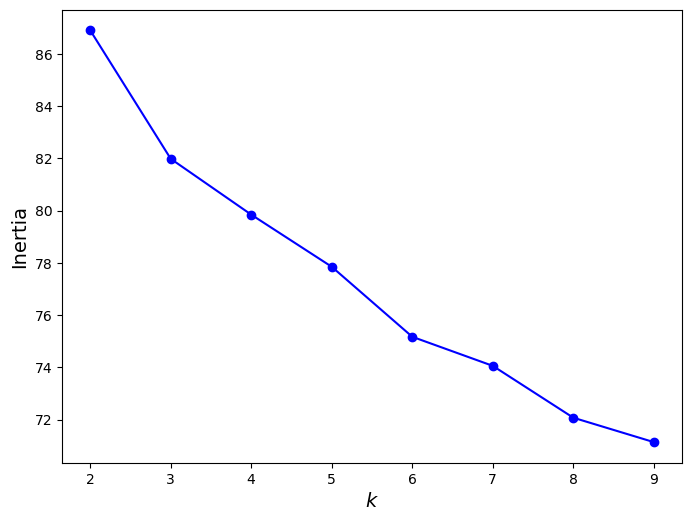

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

2.1 Implement K-Means Clustering

In [12]:
# set number of clusters
kclusters = 3

SYD_grouped_clustering = SYD_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SYD_grouped_clustering)

In [13]:
# add clustering labels
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

neighborhoods_venues_sorted['Cluster Labels'].dropna(axis = 0,inplace= True)
neighborhoods_venues_sorted['Cluster Labels'].astype('int')
neighborhoods_venues_sorted.head()

,Cluster Labels,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,ABBOTSBURY,Park,Convenience Store,Bus Stop,Other Repair Shop,Paper / Office Supplies Store,Pakistani Restaurant,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture
1,0,ABBOTSFORD,Café,Park,Wine Shop,Pizza Place,Thai Restaurant,Organic Grocery,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture
2,0,ALEXANDRIA,Café,Pizza Place,Bar,Hardware Store,Flea Market,Lebanese Restaurant,Australian Restaurant,Flower Shop,Basketball Stadium,Italian Restaurant
3,1,ALFORDS POINT,Fried Chicken Joint,Fast Food Restaurant,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym
4,0,ALLAMBIE HEIGHTS,Café,Tennis Court,ATM,Opera House,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop


In [14]:
uniqueValues, occurCount = np.unique(labels, return_counts=True)
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1 2]
Occurrence Count :  [146 193  61]


In [17]:
SYD_merged = SYD_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
SYD_merged = SYD_merged.join(neighborhoods_venues_sorted.set_index('Suburb'), on='Suburb')

In [18]:
SYD_merged.dropna(axis = 0,inplace= True)
SYD_merged['Cluster Labels'] = SYD_merged['Cluster Labels'].astype('int')
SYD_merged.head() # check the last columns!

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,EAST KILLARA,-33.755482,151.181200,2,Yoga Studio,Park,Pool,Polish Restaurant,Outlet Store,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop
1,TURRAMURRA,-33.735435,151.130065,1,Bakery,Café,Pizza Place,Pharmacy,Persian Restaurant,Liquor Store,Bus Station,Convenience Store,Bar,Supermarket
2,CANADA BAY,-33.848513,151.097582,1,Golf Course,Baseball Field,Sports Bar,Soccer Field,Opera House,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop
3,WAREEMBA,-33.857500,151.131951,0,Italian Restaurant,Wine Shop,Grocery Store,Hobby Shop,Café,Thai Restaurant,ATM,Other Repair Shop,Outlet Store,Outdoors & Recreation
4,ROSEVILLE CHASE,-33.774722,151.200278,1,Shopping Mall,Beach,Construction & Landscaping,Astrologer,Outdoor Gym,Park,Paper / Office Supplies Store,Pakistani Restaurant,Outlet Store,Outdoors & Recreation


-------------------------------------
### 3. Visuailzation  
3.1 Visuailze the clustering result on the real map

In [19]:
# create map
map_clusters = folium.Map(location=[-33.85303205312355, 151.2109030798055], zoom_start=11)

colors = ['#2987f2','#13f2ad','#e5480f']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SYD_merged['Latitude'], SYD_merged['Longitude'], SYD_merged['Suburb'], SYD_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

3.1 Viusualize the deatiled information of each cluster

In [20]:
def count_venues(cluster_number,merged_data):
    cluster_data = merged_data[merged_data['Cluster Labels'] == cluster_number].reset_index()
    cluster_data =  cluster_data[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']]
    
    df1 = cluster_data['1st Most Common Venue'].to_frame().rename(columns={'1st Most Common Venue':'Most Common Venue'})
    df2 = cluster_data['2nd Most Common Venue'].to_frame().rename(columns={'2nd Most Common Venue':'Most Common Venue'})
    df3 = cluster_data ['3rd Most Common Venue'].to_frame().rename(columns={'3rd Most Common Venue':'Most Common Venue'})
    df_concated = pd.concat([df1, df2,df3], ignore_index=True)
    
    df_grouped = df_concated['Most Common Venue'].value_counts().rename_axis('Most Common Venue').reset_index(name='counts')[:5]
    return df_grouped

In [21]:
cluster_1 = count_venues(0,SYD_merged)
cluster_2 = count_venues(1,SYD_merged)
cluster_3 = count_venues(2,SYD_merged)

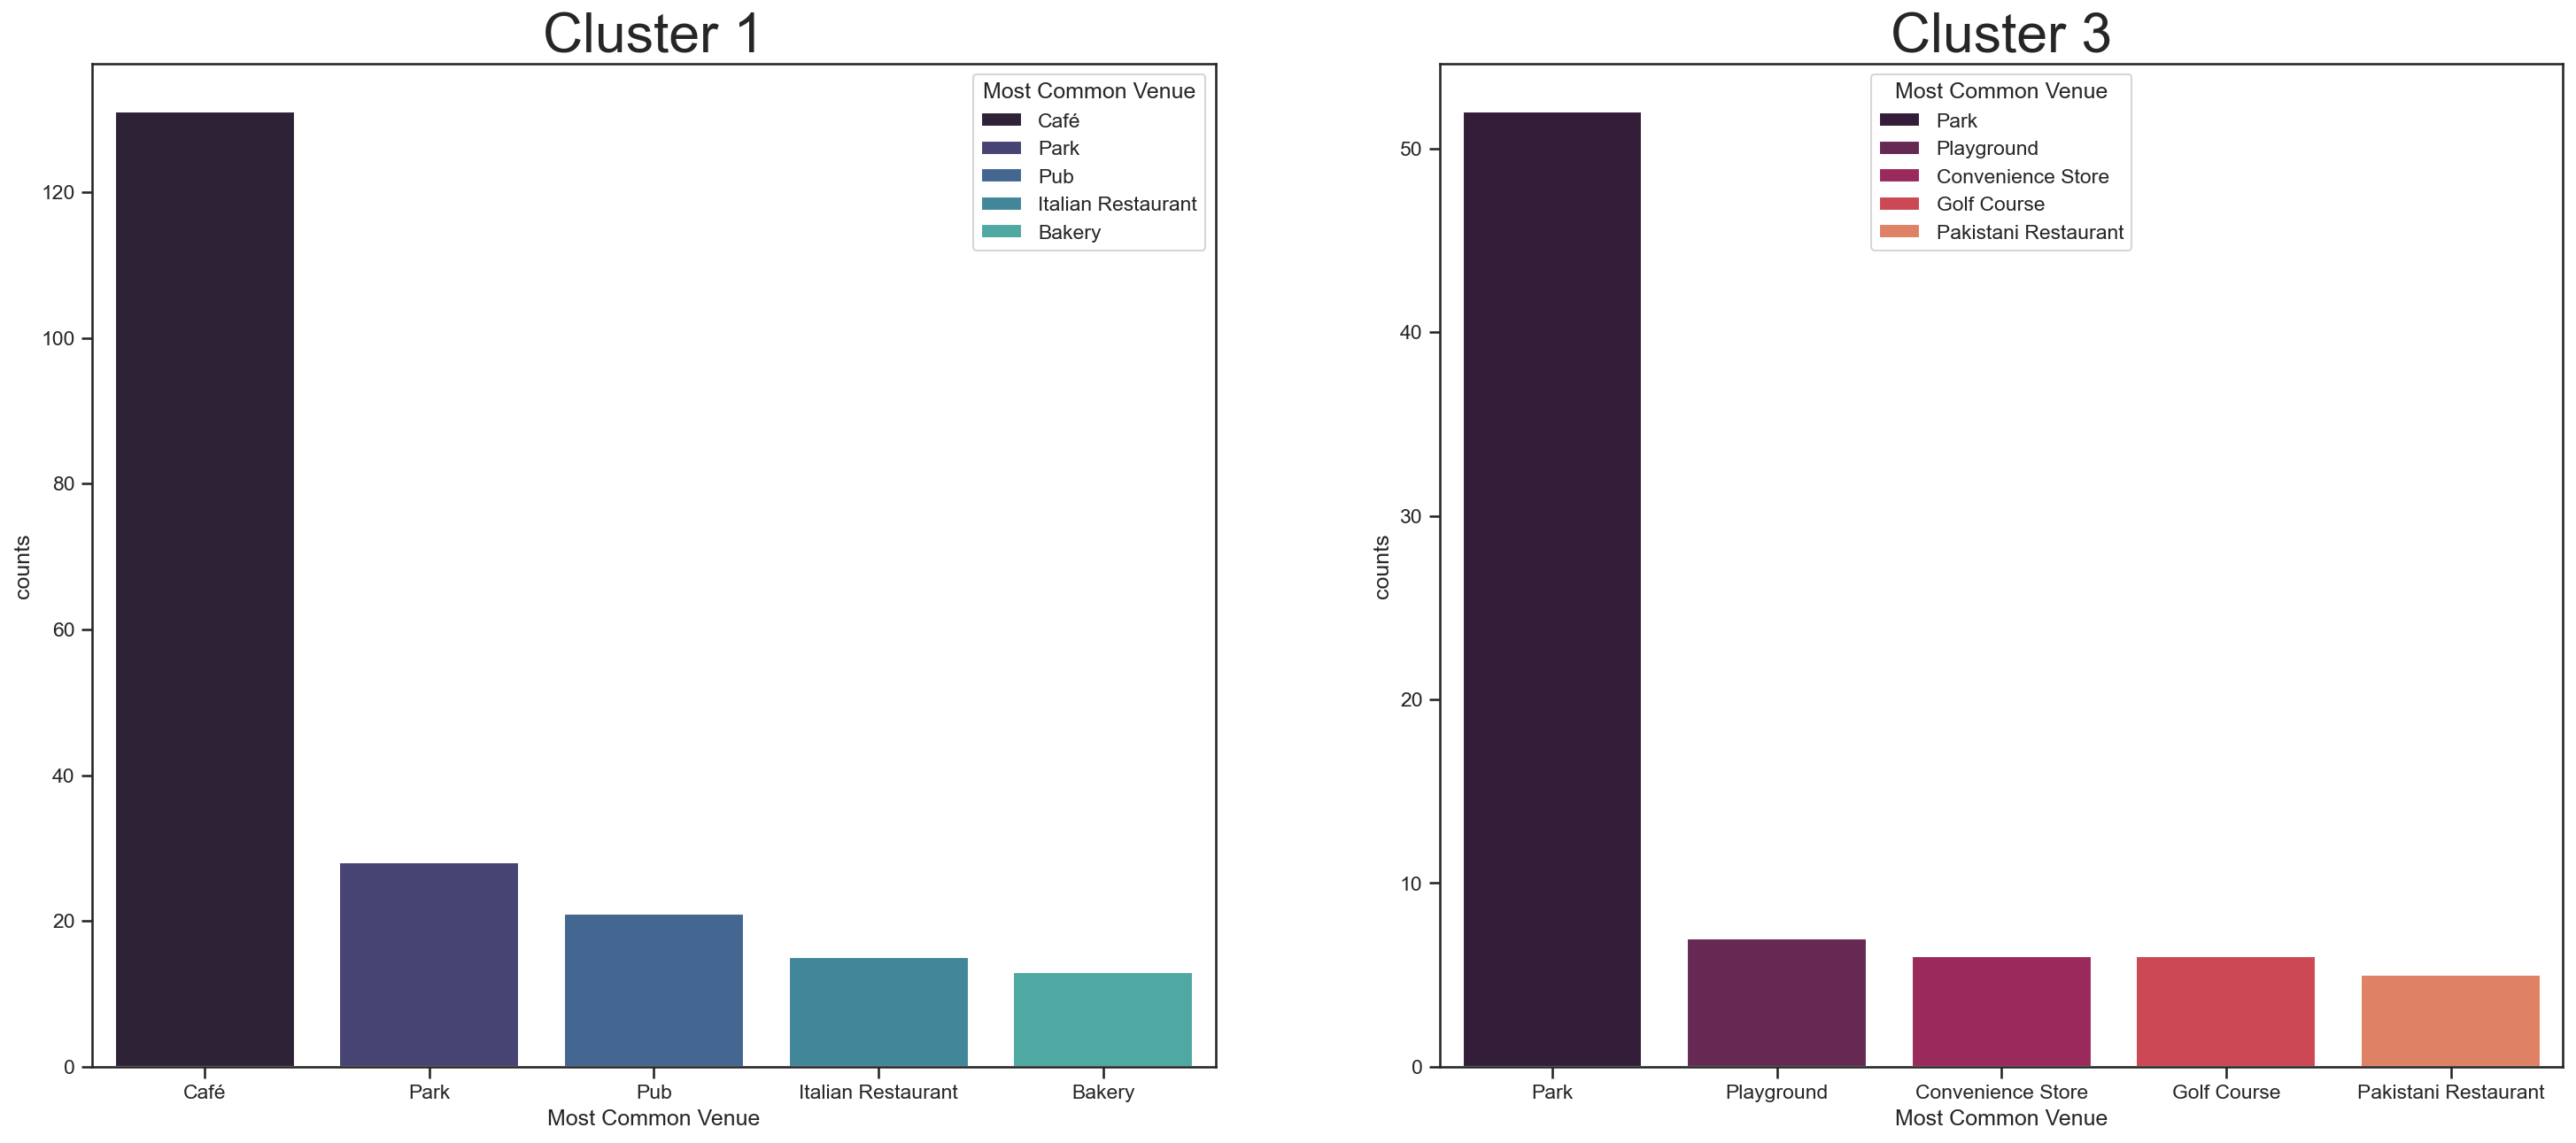

In [22]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_style("ticks")

fig, axes = plt.subplots(1, 2, figsize=(24,10))
sns.set_palette("mako")
ax1 = sns.barplot(ax = axes[0], x='Most Common Venue', y="counts", hue ='Most Common Venue', data=cluster_1,dodge=False)
ax1.set_title("Cluster 1",fontsize=30)
sns.set_palette("rocket")
ax1.figure.savefig("1.png")

ax2 = sns.barplot(ax = axes[1], x='Most Common Venue', y="counts", hue ='Most Common Venue', data=cluster_3,dodge=False)
ax2.set_title("Cluster 3",fontsize=30)
ax2.figure.savefig("3.png")


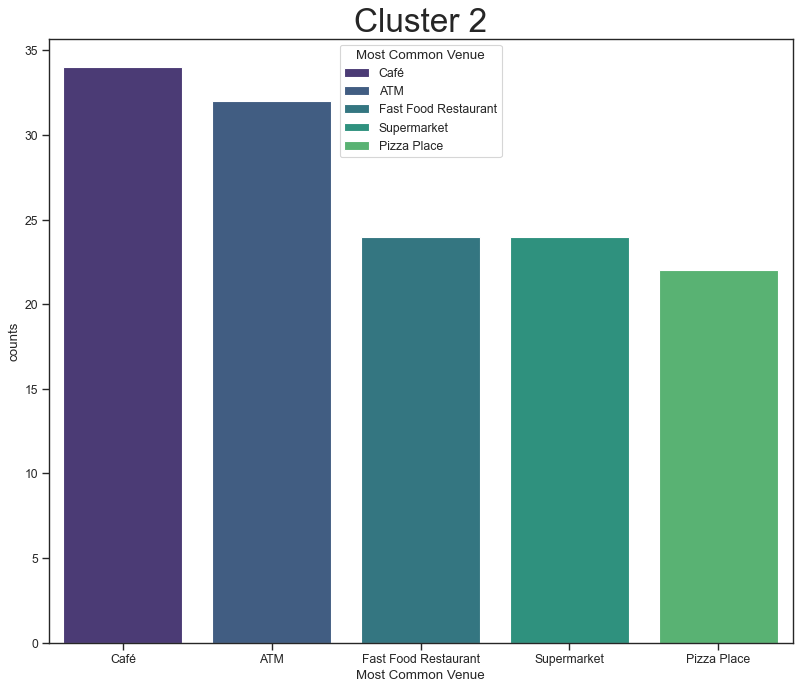

In [41]:
sns.set(rc={"figure.dpi":80, 'savefig.dpi':150})
sns.set_style("ticks")
sns.set_palette("viridis")
plt.figure(figsize=(12,10))


ax = sns.barplot(x='Most Common Venue', y="counts", hue ='Most Common Venue', data=cluster_2,dodge=False).set_title("Cluster 2",fontsize=30)
ax.figure.savefig("2.png")

### _Reference_ 
[Coursear Applied Data Science Capstone Week 3 Lab](https://www.coursera.org/learn/applied-data-science-capstone/ungradedLti/f0QY7/segmenting-and-clustering-neighborhoods-in-new-york-city)  
[NSW Government Spatial Collaboration Portal](https://portal.spatial.nsw.gov.au/portal/apps/sites/#/home)